In [126]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [127]:
# Load the dataset
file_path = 'Mall_Customers.csv'
mall_customers = pd.read_csv(file_path)

# Display the first few rows of the dataframe to check the contents
print(mall_customers.head())

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


In [128]:
# Check for any missing values
print(mall_customers.isnull().sum())

# Check the data types of the columns
print(mall_customers.dtypes)

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64
CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object


In [129]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode the 'Gender' column
mall_customers['Gender'] = label_encoder.fit_transform(mall_customers['Gender'])

# Drop the 'CustomerID' column as it's not needed
mall_customers = mall_customers.drop('CustomerID', axis=1)

# Display the modified DataFrame to verify changes
print(mall_customers.head())

   Gender  Age  Annual Income (k$)  Spending Score (1-100)
0       1   19                  15                      39
1       1   21                  15                      81
2       0   20                  16                       6
3       0   23                  16                      77
4       0   31                  17                      40


In [130]:
# Select features to scale, excluding the 'Gender' column
features_to_scale = mall_customers.drop(['Gender'], axis=1)

# Initialize the StandardScaler object
scaler = StandardScaler()

# Scale the selected features
scaled_features = scaler.fit_transform(features_to_scale)

# Convert the scaled features into a DataFrame
scaled_features_df = pd.DataFrame(scaled_features, columns=features_to_scale.columns)

# Combine the scaled features with the 'Gender' column
mall_customers_scaled = pd.concat([scaled_features_df, mall_customers['Gender']], axis=1)

# Display the results
print(mall_customers_scaled.head())

        Age  Annual Income (k$)  Spending Score (1-100)  Gender
0 -1.424569           -1.738999               -0.434801       1
1 -1.281035           -1.738999                1.195704       1
2 -1.352802           -1.700830               -1.715913       0
3 -1.137502           -1.700830                1.040418       0
4 -0.563369           -1.662660               -0.395980       0


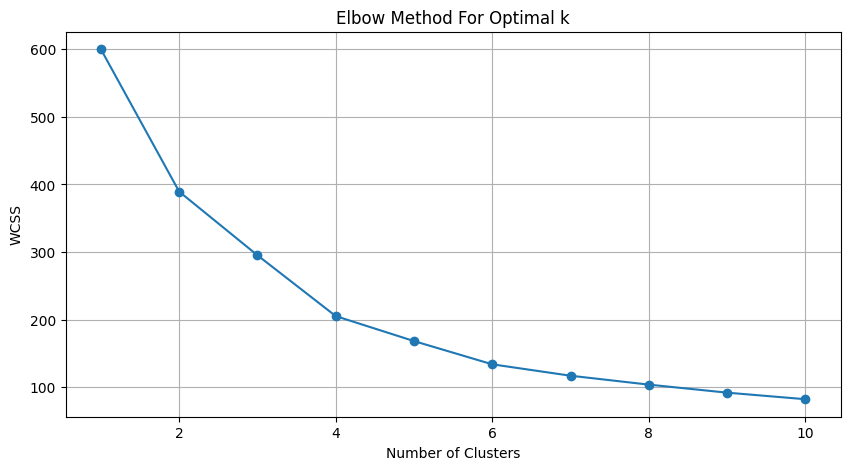

In [131]:
# Use the elbow method to determine the optimal number of clusters
wcss = []
for i in range(1, 11):  # Test different numbers of clusters from 1 to 10
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(scaled_features_df)  
    wcss.append(kmeans.inertia_)

# Plot the WCSS values to visualize the elbow
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

## Elbow Method Result Interpretation

The graph above displays the **WCSS (Within Cluster Sum of Squares)** values calculated for different numbers of clusters using the K-means algorithm. As observed, there is a decrease in WCSS values as the number of clusters increases. However, beyond a certain point, the rate of this decrease significantly diminishes. This point, commonly referred to as the "elbow," represents a breakpoint where the optimal number of clusters can be determined.

### Observations:

- **Plateauing of Decrease:** Upon careful examination of the graph, it is evident that the decrease in WCSS values begins to plateau when the number of clusters reaches five, continuing at a relatively steady decline thereafter.
- **Efficiency and Adequacy:** This observation suggests that five clusters are sufficient and appropriate for meaningfully segmenting our dataset. Increasing the number of clusters could add complexity to the model without providing a noticeable improvement.
- **Strategic Decision:** Therefore, choosing five clusters is considered the most logical approach both in terms of efficiency and adequacy.

### Conclusion:

Using this analysis, the determined five clusters will allow us to **better understand customer behaviors and preferences**, enabling the development of tailored marketingstrategies.


In [132]:
# Apply K-means clustering with the optimal number of clusters (5)
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)

# Fit and predict using only the numerical features (excluding 'Gender' and any other cluster columns)
cluster_labels = kmeans.fit_predict(scaled_features_df)

# Add the cluster labels to the original DataFrame
mall_customers['Cluster'] = cluster_labels

# Calculate and display the mean values for each cluster (excluding 'Gender' and 'Cluster' columns)
cluster_centers = kmeans.cluster_centers_
clusters_summary = pd.DataFrame(cluster_centers, columns=features_to_scale.columns)
print(clusters_summary)

# Display the first few customers and their assigned clusters
print(mall_customers.head())

        Age  Annual Income (k$)  Spending Score (1-100)
0  1.204841           -0.235773               -0.052368
1  0.073331            0.974945               -1.197297
2 -0.428806            0.974847                1.216085
3  0.531074           -1.290508               -1.236467
4 -0.980679           -0.743060                0.467440
   Gender  Age  Annual Income (k$)  Spending Score (1-100)  Cluster
0       1   19                  15                      39        4
1       1   21                  15                      81        4
2       0   20                  16                       6        3
3       0   23                  16                      77        4
4       0   31                  17                      40        4



Combined Cluster Summary (Numerical Features + Gender Distribution):
               Age  Annual Income (k$)  Spending Score (1-100)  Female  Male
Cluster                                                                     
0        55.638298           54.382979               48.851064      27    20
1        39.871795           86.102564               19.358974      19    20
2        32.875000           86.100000               81.525000      22    18
3        46.250000           26.750000               18.350000      12     8
4        25.185185           41.092593               62.240741      32    22


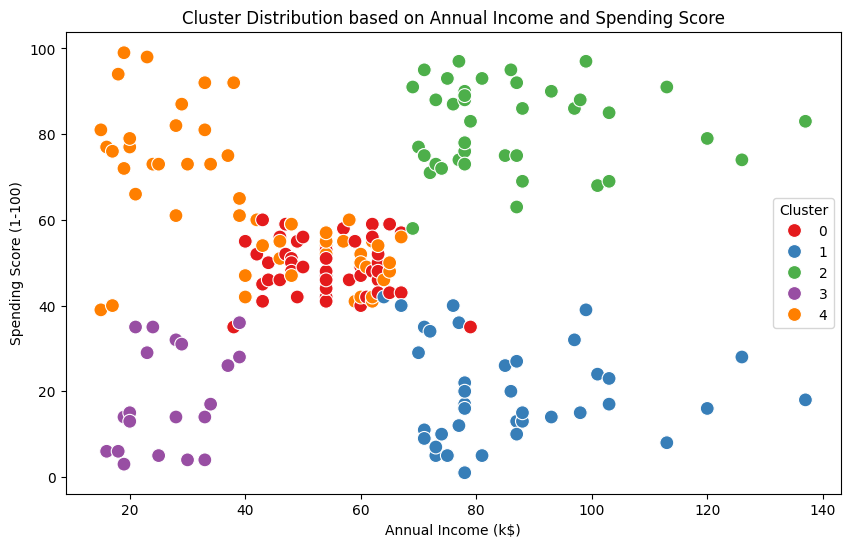

In [133]:
# Calculate the mean values for each cluster for all numerical features, excluding Gender
cluster_summary = mall_customers.drop(['Gender'], axis=1).groupby('Cluster').mean()

# Count the number of males and females in each cluster
gender_counts = mall_customers.groupby('Cluster')['Gender'].value_counts().unstack().fillna(0)
gender_counts.columns = ['Female', 'Male']  # Rename columns for better readability

# Combine the numerical summary and gender counts into one table
cluster_summary_combined = pd.concat([cluster_summary, gender_counts], axis=1)

# Display the combined summary in a cleaner format
print("\nCombined Cluster Summary (Numerical Features + Gender Distribution):")
print(cluster_summary_combined)

# Visualize cluster distribution based on Age, Annual Income, and Spending Score
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster', data=mall_customers, palette='Set1', s=100)
plt.title('Cluster Distribution based on Annual Income and Spending Score')
plt.show()

# Customer Segmentation Analysis

In this project, I used **K-means clustering** to segment mall customers based on their income and spending habits. My goal was to identify key customer groups and provide insights for tailored marketing strategies.

## Key Findings:

I divided the customers into 5 different clusters. Below is a brief summary of the characteristics of each cluster.

### Cluster 0: **Older, Medium Income, Moderate Spending Score**
- **Average Age**: 55.6
- **Annual Income**: 54.3k
- **Spending Score**: 48.8
- **Gender Distribution**: 27 Female, 20 Male

**Marketing Strategy**:
This segment consists of older customers with moderate spending behavior. I could increase their spending in the mall by offering a loyalty program with age-appropriate products and services.

### Cluster 1: **High Income, Low Spending Score**
- **Average Age**: 39.8
- **Annual Income**: 86.1k
- **Spending Score**: 19.4
- **Gender Distribution**: 19 Female, 20 Male

**Marketing Strategy**:
Despite their high income, these customers spend less in the mall. I could encourage them to spend more by offering VIP membership programs or personalized services.

### Cluster 2: **Young, High Income, High Spending Score**
- **Average Age**: 32.9
- **Annual Income**: 86.1k
- **Spending Score**: 81.5
- **Gender Distribution**: 22 Female, 18 Male

**Marketing Strategy**:
This is one of the most valuable segments for the mall. By offering premium products and exclusive deals, I can increase their loyalty. Additionally, digital marketing campaigns with personalized offers could further engage this group.

### Cluster 3: **Older, Low Income, Low Spending Score**
- **Average Age**: 46.2
- **Annual Income**: 26.7k
- **Spending Score**: 13.3
- **Gender Distribution**: 12 Female, 8 Male

**Marketing Strategy**:
This segment consists of lower-income customers with low spending behavior. By offering budget-friendly products and discounts, I could encourage them to visit and shop more frequently.

### Cluster 4: **Young, Medium Income, Moderate-High Spending Score**
- **Average Age**: 25.2
- **Annual Income**: 41.1k
- **Spending Score**: 62.2
- **Gender Distribution**: 32 Female, 22 Male

**Marketing Strategy**:
This younger, middle-income group could be targeted through seasonal campaigns and fun events. Social media marketing and digital promotions would be effective in engaging this segment.

---

## Conclusion and Marketing Strategy

Based on these findings, I recommend the following marketing strategies:

- **Personalized Offers**: Tailor special offers for high-income, high-spending customers (Cluster 2) to increase loyalty and boost sales.
- **Loyalty Programs**: Engage middle-aged, moderate-spending customers (Cluster 0) with loyalty programs and age-appropriate offers to increase their shopping frequency.
- **Discounts and Promotions**: Offer discounts and promotions to attract low-income customers (Cluster 3) to visit the mall more often.
- **Event Marketing**: Attract younger segments (Clusters 4 and 2) with fun evens and social media marketing to boost engagement and loyalty.
s and social media marketing to boost engagement and loyalty.
